# <center> Using LGBM Predicting Donors Choose</center>

--------

## Imports

In [1]:
import gc
import os
import re

import numpy as np
import pandas as pd

from wordcloud import WordCloud
import lightgbm as lgb
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Functions

In [2]:
def date_prep(train):
    train['project_submitted_datetime'] = pd.to_datetime(train['project_submitted_datetime'])
    train['datetime_year'] = train['project_submitted_datetime'].dt.year
    train['datetime_month'] = train['project_submitted_datetime'].dt.month
    return(train)
def gender_features(train):
    conditions = [(train.teacher_prefix == 'Mr.'), 
                  (train.teacher_prefix == 'Mrs.') | (train.teacher_prefix == 'Ms.')]
    choices = ['Male', 'Female']
    train['gender'] = np.select(conditions, choices, default='Unk')
    return(train)
def make_sim(n='p081434'):
    """
    Makes a semi-brute forced dataset based off the entry n, with variable:
    Months (jan-dec), 
    Pronouns (not teacher or dr), 
    Previous Entries(0:30),
    to see what combination may have a higher success rate
    """
    test = pd.DataFrame(train.loc[n]).transpose()
    del test['project_is_approved']
    
    change_dict = {"prefix":['Mrs.','Ms.','Mr.'],
        "date":['2017-01-26','2017-02-26','2017-03-26','2017-04-26','2017-05-26','2017-06-26',
        '2017-07-26','2017-08-26','2017-09-26','2017-10-26','2017-11-26','2017-12-26',],
        "prev" : [x for x in range(0,10)]}

    for i in range(1000):
        test.loc[n+str(i)] = test.loc[n].transpose()
        test.set_value(n+str(i),'teacher_prefix',np.random.choice(change_dict['prefix']))
        test.set_value(n+str(i),'project_submitted_datetime',np.random.choice(change_dict['date']))
        test.set_value(n+str(i),'teacher_number_of_previously_posted_projects',np.random.choice(change_dict['prev']))
        
    test.index.rename = 'id'
    return(test)


In [4]:
#Am I using the kaggle test set
kaggle = False

#Am I making simulating variable situations to be tested on. 
sim = False

#Kaggle & Sim use 'test' so dont use both

In [3]:
train = pd.read_csv('./Input/train.csv', low_memory=False, index_col='id')
if kaggle: 
    if sim == False:
        test = pd.read_csv('./Input/test.csv', low_memory=False, index_col='id')

res = pd.read_csv('./Input/resources.csv', low_memory=False, index_col='id')

NameError: name 'kaggle' is not defined

### Simulated Data

In [6]:
#We want to simulate how a failed project might have had a higher chance of success.
#So we will pull out an instance that we know has failed, 
    #delete that instance from our training set,
    #make 100+ copies of that instance
    #generate modified data with changes in features, for each instance
        #each should be randomly assigned
    #finally estimate liklihood for success for each instance.
        #which instance has the highest chance?

In [7]:
#making a dataset which has variable situations that 'p039654' may be under
if sim:
    test = make_sim('p081434')
    train = train.drop('p081434',axis=0)

## Preprocessing

### 1.1 Resource Intergration
Here we evaluate how much each project/proposal will cost and/or how big they are

In [ ]:
res['cost'] = res['quantity'] * res['price']
res_agg = res.groupby('id').agg({'description': ['nunique'], 'quantity': ['sum'], 'cost': ['mean', 'sum','median','max','min']})
res_agg.columns = ['unique_items','total_quantity', 'mean_cost', 'total_cost','median_cost','most_exp_cost','least_exp_cost']
res_agg.reset_index(inplace=True)


train = train.merge(res_agg, left_index=True, right_on='id')
if (kaggle | sim): 
    if sim : 
        for i in res_agg.columns:
            if i != 'id':
                test[i] = res_agg[res_agg['id']=='p081434'][i].values[0]
    else:
        test =  test.merge(res_agg, left_index=True, right_on='id')

### 1.2 Preprocessing of features

#### Cat Preprocessing

There are 51 States, because of 50 + DC

In [ ]:
train.isnull().sum()[train.isnull().sum()>0]

In [ ]:
train.teacher_prefix[train.teacher_prefix.isnull()] = 'Teacher'
try: 
    test.teacher_prefix[test.teacher_prefix.isnull()] = 'Teacher'
except:
    pass

date_prep(train)
train = gender_features(train)

if (kaggle | sim): 
    date_prep(test)
    test = gender_features(test)
    del test['project_submitted_datetime'], test['project_subject_subcategories']

del train['project_submitted_datetime'], train['project_subject_subcategories']
del date_prep, gender_features

In [ ]:
gc.collect()

#### EDA

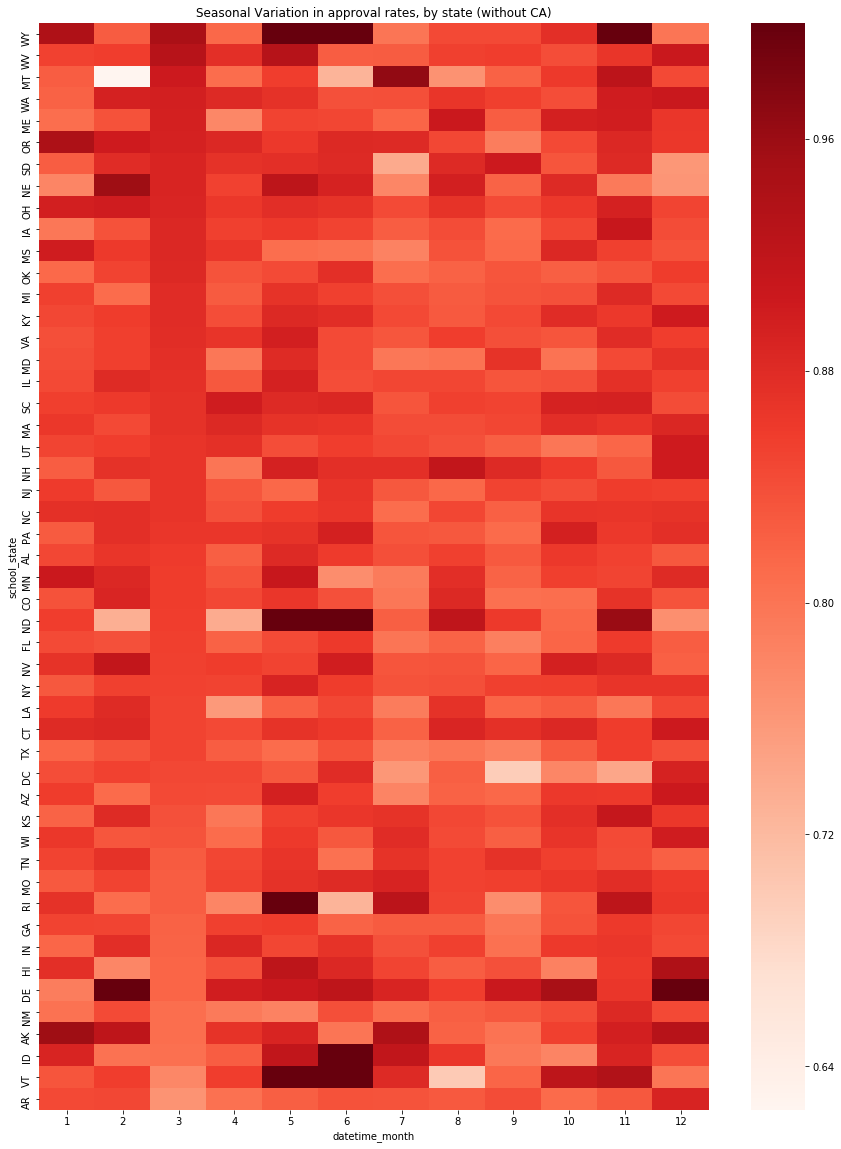

In [16]:
loan = train.groupby(['school_state', 'datetime_month'])['project_is_approved'].mean().unstack()
loan = loan.sort_values([3], ascending=False)
f, ax = plt.subplots(figsize=(15, 20)) 
loan = loan.fillna(0)
loan = loan.drop('CA',axis=0)
temp = sns.heatmap(loan, cmap='Reds')
plt.title('Seasonal Variation in approval rates, by state (without CA)')
plt.show()

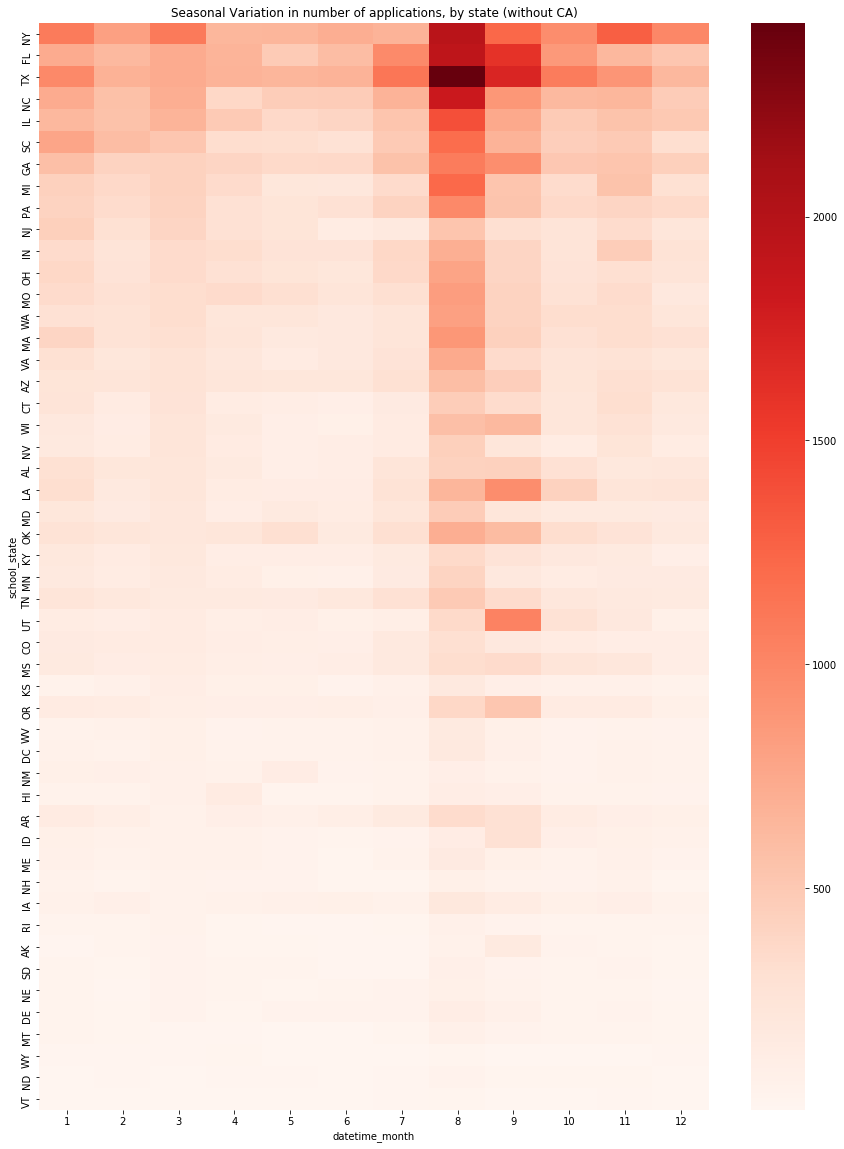

In [17]:
loan = train.groupby(['school_state', 'datetime_month'])['total_cost'].count().unstack()
loan = loan.sort_values([3], ascending=False)
f, ax = plt.subplots(figsize=(15, 20)) 
loan = loan.fillna(0)
loan = loan.drop('CA',axis=0)
temp = sns.heatmap(loan, cmap='Reds')
plt.title('Seasonal Variation in number of applications, by state (without CA)')
plt.show()

In [18]:
train.columns

Index(['teacher_id', 'teacher_prefix', 'school_state',
       'project_grade_category', 'project_subject_categories', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'id', 'unique_items', 'total_quantity', 'mean_cost', 'total_cost',
       'median_cost', 'most_exp_cost', 'least_exp_cost', 'datetime_year',
       'datetime_month', 'gender'],
      dtype='object')

In [19]:
gen_mon_app = train.groupby(['datetime_month','gender'])['project_is_approved'].mean().reset_index()
gen_mon_cost = train.groupby(['datetime_month','project_is_approved'])['mean_cost'].mean().reset_index()

/Users/Nahel/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)


Text(0.5,1,'Approval rate, by month, by gender (ci:80)')

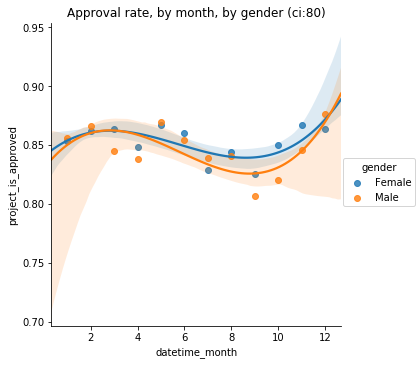

In [20]:
sns.lmplot(x="datetime_month", y="project_is_approved", hue="gender", 
           data=gen_mon_app[gen_mon_app['gender']!='Unk'], 
           order=3,ci=80)
plt.title('Approval rate, by month, by gender (ci:80)')

Text(0.5,1,', by month, by gender (ci:80)')

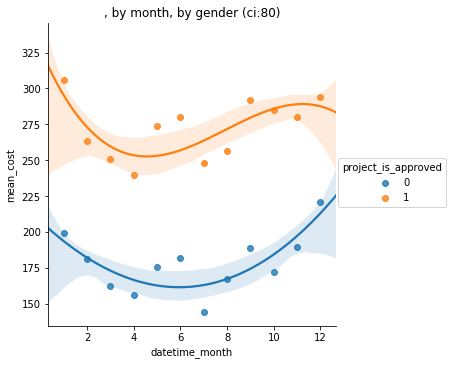

In [21]:
sns.lmplot(x="datetime_month", y="mean_cost", hue="project_is_approved", 
           data=gen_mon_cost, 
           order=3,ci=80)
plt.title(', by month, by gender (ci:80)')

In [22]:
#del gen_mon
#del prev_mon

In [23]:
gc.collect()

8091

##### Encoding labels

In [24]:
# Because of trees do no need onehot encoding, label encoding is used
cols  = ['gender',
        'teacher_prefix', 
        'school_state',
        'datetime_year',
        'datetime_month',
        'project_grade_category']

for c in tqdm_notebook(cols):
    encod = LabelEncoder()
    encod.fit(train[c].astype(str))
    train[c] = encod.transform(train[c].astype(str))
    if (kaggle | sim):        
        test[c] = encod.transform(test[c].astype(str))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

#### Num Preprocessing

In [25]:
num_features  = ['teacher_number_of_previously_posted_projects',
                 'total_quantity', 'mean_cost', 'total_cost','unique_items']

In [47]:
SS = StandardScaler()
train[num_features] = SS.fit_transform(train[num_features])
if (kaggle | sim): test[num_features] = SS.transform(test[num_features])

NameError: name 'StandardScaler' is not defined

In [27]:
del num_features, StandardScaler, SS

In [28]:
gc.collect()

14

#### Text Preprocessing

In [29]:
all_stopwords = [x for x in 'abcdefghijklmnopqrstuvwxyz']
for j in ['student','students','education',]:
    all_stopwords.append(j)
all_stopwords += stopwords.words("english")

In [30]:
def scrub(text):
    text = text.strip().lower()
    text = re.sub('\W+',' ', text)    
    text = re.sub(r'_', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\:', ' ', text)
    text = re.sub(r'\+', ' ', text)
    text = re.sub(r'\=', ' ', text)
    text = re.sub(r'(\")', ' ', text)
    text = re.sub(r'(\r)', ' ', text)
    text = re.sub(r'(\n)', ' ', text)
    text = re.sub(r'(\\)', ' ', text)
    text = re.sub('n t ','n\'t ', text)
    text = re.sub(' re ',' are ', text)
    text = re.sub(r'(\r\n)', ' ', text)
    text = re.sub(r'\"\"\"\"', ' ', text)
    text = re.sub(' i m ',' i\'m ', text)
    return(text)
def swords(text):
    text = ' '.join([word for word in text.split() if word not in (all_stopwords)])
    return(text)

##### Project Category Preprocessing

In [31]:
def cat(text):
    text =[word for word in text.split(',')]
    text =[word.strip() for word in text]
    return(text)

In [32]:
def cat(text):
    text =[word for word in text.split(',')]
    text =[word.strip() for word in text]
    return(text)

clean_cats = train.project_subject_categories.apply(lambda x:cat(x))
p = pd.get_dummies(clean_cats.apply(pd.Series).stack()).sum(level=0).reset_index(drop=True)
del p['Warmth']

In [33]:
k = p.join(train.reset_index(drop=True).project_is_approved)

In [34]:
k = k.groupby('project_is_approved').sum().transpose()
k['avg'] = k[1]/(k[1] + k[0])
k['count'] = (k[1] + k[0])

In [35]:
k['percent_of_total'] = k['count']/len(train)

In [36]:
k = k.sort_values('count',ascending=False)

In [37]:
k

project_is_approved,0,1,avg,count,percent_of_total
Literacy & Language,11634.0,75354.0,0.866257,86988.0,0.477749
Math & Science,11041.0,58207.0,0.840559,69248.0,0.380318
Health & Sports,3711.0,20000.0,0.843490,23711.0,0.130224
Special Needs,3861.0,19019.0,0.831250,22880.0,0.125660
Applied Learning,3543.0,16760.0,0.825494,20303.0,0.111507
Music & The Arts,2754.0,14300.0,0.838513,17054.0,0.093663
History & Civics,1425.0,8301.0,0.853486,9726.0,0.053416
Care & Hunger,203.0,2124.0,0.912763,2327.0,0.012780


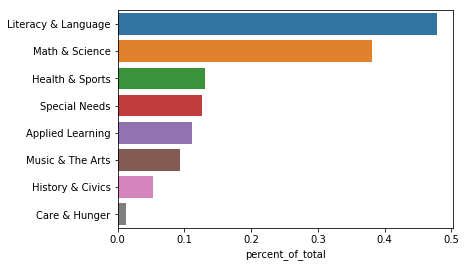

In [38]:
sns.barplot(k.percent_of_total,k.index)

In [39]:
train = train.reset_index(drop=True)
train = train.merge(p,left_index=True,right_index=True)

In [40]:
if (kaggle | sim):
    clean_cats = test.project_subject_categories.apply(lambda x:cat(x))
    for i in p.columns:
        test[i]=0
    p = pd.get_dummies(clean_cats.apply(pd.Series).stack()).sum(level=0).reset_index(drop=True)
    if p.columns.contains('Warmth'):
        del(p['Warmth'])
    for i in p.columns:
        test[i] = p[i]
    del test['project_subject_categories']

In [41]:
del train['project_subject_categories'], p, cat

##### Essay Preprocessing

  
#### Before May 17th, 2016:

- project_essay_1: "Introduce us to your classroom"
- project_essay_2: "Tell us more about your students"
- project_essay_3: "Describe how your students will use the materials you're requesting"
- project_essay_4: "Close by sharing why your project will make a difference"

#### May 17th, 2016 and beyond:

- project_essay_1: "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."
- project_essay_2: "About your project: How will these materials make a difference in your students' learning and improve their school lives?"

#### Plan
- Combine essay_1 and essay_2 before May 17th to make "student_description" and use essay_1 after May 17th directly
- Combine essay_3 and essay_4 before May 17th to make "project_description" and use essay_2 after May 17th directly

In [42]:
def essay_convert(train):
    # Making the First essay : student_description
    train['student_description']=train['project_essay_1']
    train.loc[train.project_essay_3.notnull(),'student_description']=train.loc[train.project_essay_3.notnull(),'project_essay_1']+train.loc[train.project_essay_3.notnull(),'project_essay_2']

    # Making the second essay : project_description
    train['project_description']=train['project_essay_2']
    train.loc[train.project_essay_3.notnull(),'project_description']=train.loc[train.project_essay_3.notnull(),'project_essay_3']+train.loc[train.project_essay_3.notnull(),'project_essay_4']

    # Removing original essays
    del train['project_essay_1']
    del train['project_essay_2']
    del train['project_essay_3']
    del train['project_essay_4']
    return(train)

In [43]:
essay_convert(train)
if (kaggle | sim): essay_convert(test)
gc.collect()

del essay_convert

KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


##### Scrub Text Features

In [44]:
text_features = ['project_title', 'project_resource_summary',
                'project_description', 'student_description']

In [45]:
for j in tqdm_notebook(text_features):
    n_col = 'processed_'+j
    train[n_col] = train[j].apply(lambda x: scrub(x)).apply(lambda x: swords(x))
    if (kaggle | sim): test[n_col] = test[j].apply(lambda x: scrub(x)).apply(lambda x: swords(x))

gc.collect()
for i in text_features:
    del train[i]
    if (kaggle | sim): del test[i]

del stopwords, all_stopwords, text_features, swords

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

In [46]:
gc.collect()

56

## Word Clouds?

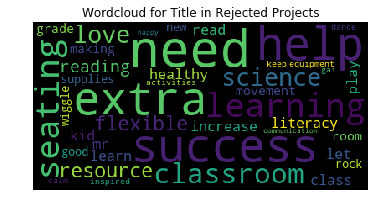

In [47]:
wordcloud = WordCloud(
                          background_color='black',
                          max_words=40,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(train[train.project_is_approved==0].processed_project_title))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title('Wordcloud for Title in Rejected Projects')
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=2400)

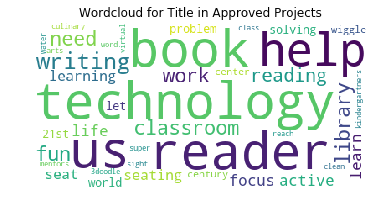

In [48]:
wordcloud = WordCloud(
                          background_color='white',
                          max_words=40,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(train[train.project_is_approved==1].processed_project_title))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Wordcloud for Title in Approved Projects')
plt.show()
fig.savefig("word1.png", dpi=2400);

In [49]:
del wordcloud

## Modeling

### Tfidf & X,y Assignment

In [50]:
gc.collect()

2448

In [51]:
cols = [
    'processed_project_title',
    'processed_project_resource_summary', 
    'processed_project_description',
    'processed_student_description']

In [52]:
for i in cols:
    print("Average length in {} is {} words".format(i,str(round(train[i].str.len().mean()))))

Average length in processed_project_title is 25 words
Average length in processed_project_resource_summary is 81 words
Average length in processed_project_description is 523 words
Average length in processed_student_description is 414 words


In [53]:
n_features = [
    100, 
    100, 
    2000,
    2000]

In [54]:
gc.collect()

122

In [55]:
for c_i, c in tqdm_notebook(enumerate(cols)):
    tfidf = TfidfVectorizer(
        ngram_range=(1,2),
        max_features=n_features[c_i])

    tfidf.fit(train[c])

    tfidf_train = np.array(tfidf.transform(train[c].values).toarray(), dtype=np.float16)
    for i in range(n_features[c_i]):
        train[c + '_contains_-' + tfidf.get_feature_names()[i]] = tfidf_train[:, i]
    if (kaggle | sim):
        tfidf_test = np.array(tfidf.transform(test[c].values).toarray(), dtype=np.float16)
        for i in range(n_features[c_i]):
            test[c + '_contains_-' + tfidf.get_feature_names()[i]] = tfidf_test[:, i]

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [56]:
for i in cols:
    del train[i]
    if (kaggle | sim): del test[i]

if (kaggle|sim): del tfidf_test
del tfidf_train, tfidf

In [57]:
drop_cols = ['project_is_approved','id','teacher_id']

X = train.drop(drop_cols, axis=1)
y = train['project_is_approved']
feature_names = list(X.columns)

In [58]:
test = test.drop('teacher_id',axis=1)

In [ ]:
X.shape[1] == test.shape[1]

True

In [ ]:
#del train

In [137]:
#if running demo, uncomment this and change test['id'].vaues -> test['index'].values
if (kaggle|sim): test = test.reset_index(drop=True)

In [139]:
X_kaggle = test.drop(drop_cols, axis=1, errors='ignore')
if kaggle: id_test = test['id'].values

### Training Best LGBM

In [ ]:
# Build the model
cnt = 0
n_splits = 5
n_repeats = 1
kf = RepeatedKFold(
    n_splits=n_splits, 
    n_repeats=n_repeats, 
    random_state=42)

for train_index, valid_index in kf.split(X):
    print('Fold {}/{}'.format(cnt + 1, n_splits))
    
    params = {'is_unbalance': True, 
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.025,
        'bagging_freq': 5,
        'verbose': 1,
        'min_gain_to_split': 3,
        'min_child_samples' : 5,

        'num_threads': 1,
        'lambda_l2': 0.08,              
        'bagging_fraction': 0.85,
        'feature_fraction': 0.85,
        'max_depth': 18,
        'num_leaves': 24,
    }  

    lgb_train = lgb.Dataset(
        X.loc[train_index], 
        y.loc[train_index], 
        feature_name=feature_names)

    lgb_valid = lgb.Dataset(
        X.loc[valid_index], 
        y.loc[valid_index])

    model = lgb.train(
        params, lgb_train,
        num_boost_round=500,
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=10,
        verbose_eval=10,)

    if cnt == 0:
        importance = model.feature_importance()
        model_fnames = model.feature_name()
        tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
        tuples = [x for x in tuples if x[1] > 0]
        print('Important features:')
        for i in range(60):
            if i < len(tuples):
                print(tuples[i])
            else:
                break
    
    cnt = cnt+1

Fold 1/5
Training until validation scores don't improve for 10 rounds.
[10]	training's auc: 0.728348	valid_1's auc: 0.71709
[20]	training's auc: 0.73181	valid_1's auc: 0.719317
[30]	training's auc: 0.735515	valid_1's auc: 0.722484
[40]	training's auc: 0.738614	valid_1's auc: 0.725246
[50]	training's auc: 0.742038	valid_1's auc: 0.727775
[60]	training's auc: 0.745503	valid_1's auc: 0.730508
[70]	training's auc: 0.7491	valid_1's auc: 0.733274
[80]	training's auc: 0.752735	valid_1's auc: 0.735694
[90]	training's auc: 0.756325	valid_1's auc: 0.73849
[100]	training's auc: 0.759514	valid_1's auc: 0.741042
[110]	training's auc: 0.762689	valid_1's auc: 0.743377
[120]	training's auc: 0.765806	valid_1's auc: 0.745605
[130]	training's auc: 0.768844	valid_1's auc: 0.747763
[140]	training's auc: 0.771713	valid_1's auc: 0.749832
[150]	training's auc: 0.774275	valid_1's auc: 0.751586
[160]	training's auc: 0.776744	valid_1's auc: 0.753161
[170]	training's auc: 0.779048	valid_1's auc: 0.754759
[180]	tr

[440]	training's auc: 0.815667	valid_1's auc: 0.782957
[450]	training's auc: 0.816741	valid_1's auc: 0.783185
[460]	training's auc: 0.817813	valid_1's auc: 0.783346
[470]	training's auc: 0.818838	valid_1's auc: 0.783462
[480]	training's auc: 0.819835	valid_1's auc: 0.783595
[490]	training's auc: 0.820808	valid_1's auc: 0.783843
[500]	training's auc: 0.821767	valid_1's auc: 0.78399
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.821767	valid_1's auc: 0.78399
Fold 3/5
Training until validation scores don't improve for 10 rounds.
[10]	training's auc: 0.726218	valid_1's auc: 0.722117
[20]	training's auc: 0.729716	valid_1's auc: 0.726304
[30]	training's auc: 0.733769	valid_1's auc: 0.729254
[40]	training's auc: 0.737383	valid_1's auc: 0.732483
[50]	training's auc: 0.740491	valid_1's auc: 0.735277
[60]	training's auc: 0.744129	valid_1's auc: 0.73804
[70]	training's auc: 0.747736	valid_1's auc: 0.7414
[80]	training's auc: 0.751684	valid_1's auc: 0.744418
[90]	training'

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=15, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [ ]:
p = model.predict(X_kaggle, num_iteration=model.best_iteration)

In [ ]:
submit = pd.DataFrame({'id':id_test,'pred':p})

In [ ]:
submit